In [15]:
# Импорт необходимыз библиотек
import sqlite3
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Создание соединения и курсора
conn = sqlite3.connect('orders.db')
cursor = conn.cursor()

Ниже - создание таблиц и заполнение их придуманными записями для иллюстрации работы запроса.

In [3]:
# Создание таблиц
cursor.execute('''
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY,
    warehouse_id INTEGER,
    delivered_at DATETIME,
    created_at DATETIME
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS order_lines (
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    FOREIGN KEY(order_id) REFERENCES orders(order_id)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT
)
''')

In [4]:
products_data = [
    (1, 'Творог'), (2, 'Молоко'), (3, 'Макароны'), (4, 'Филе курицы'),
    (5, 'Яйца'), (6, 'Мука'), (7, 'Варенье'), (8, 'Йогурт'),
    (9, 'Хлеб'), (10, 'Чай'), (11, 'Кофе'), (12, 'Сахар')
]
cursor.executemany("INSERT OR IGNORE INTO products VALUES (?, ?)", products_data)

now = datetime.now()
orders_data = [
    (1, 101, (now + timedelta(days=1)).isoformat(), (now + timedelta(days=1, minutes = -28)).isoformat()),
    (2, 101, (now + timedelta(days=2)).isoformat(), (now + timedelta(days=2, minutes = -9)).isoformat()),
    (3, 102, (now + timedelta(days=4)).isoformat(), (now + timedelta(days=4, minutes = -13)).isoformat()),
    (4, 101, (now + timedelta(days=4)).isoformat(), (now + timedelta(days=4, minutes = -25)).isoformat()),
    (5, 102, (now + timedelta(days=2)).isoformat(), (now + timedelta(days=2, minutes = -11)).isoformat()),
    (6, 102, (now + timedelta(days=1)).isoformat(), (now + timedelta(days=1, minutes = -42)).isoformat()),
]
cursor.executemany("INSERT OR IGNORE INTO orders VALUES (?, ?, ?, ?)", orders_data)

order_lines_data = [
    (1, 2, 50), (1, 8, 40), (1, 3, 30), (1, 4, 25), (1, 5, 20),
    (2, 6, 15), (2, 7, 10), (2, 8, 5), (2, 9, 3), (2, 10, 2),
    (4, 11, 1),
    
    (3, 7, 100), (3, 1, 80), (3, 4, 60), (3, 4, 40), (3, 5, 30),
    (5, 6, 20), (5, 7, 15), (5, 8, 10), (5, 9, 5), (5, 10, 3),
    (6, 11, 2), (6, 12, 1)
]
cursor.executemany("INSERT OR IGNORE INTO order_lines VALUES (?, ?, ?)", order_lines_data)


Первая задача состоит в нахождении для каждого склада пяти худших и пяти лучших товаров с точки зрения их продаж за последний месяц.

Для решения задачи создадим два CTE: *sales_data* и *ranked_sales*. В первом произвдедем соединение таблиц (внутреннее; продукты которые не покупались не привязаны ни к какому складу и поэтому их условно учитывать не будем), отфильтруем заказы по дате его создания, создадим вспомогательный атрибут *total_sold* с агрегацией по первичному ключу склада, который и покажет количество проданных единиц продукта на каждом из складов.

Во втором введем две нумерации по *total_sold* с разбиением по складам - одна пронумерует продукты от лучшего к худшему, другая - от худшего к лучшему; это соответственно *rn_desc* и *rn_asc*.

Наконец, выведем требуемую информацию, просто используя фильтрацию по этим двум столбцам таблицы *ranked_sales*.

In [5]:
query = '''
WITH sales_data AS (
    SELECT 
        o.warehouse_id,
        p.product_name,
        SUM(ol.quantity) as total_sold
    FROM orders o
    JOIN order_lines ol ON o.order_id = ol.order_id
    JOIN products p ON p.product_id = ol.product_id
    WHERE o.created_at >= DATE('now', '-1 month')
    GROUP BY o.warehouse_id, p.product_name
),
ranked_sales AS (
    SELECT 
        warehouse_id,
        product_name,
        total_sold,
        ROW_NUMBER() OVER (PARTITION BY warehouse_id ORDER BY total_sold DESC) as rn_desc,
        ROW_NUMBER() OVER (PARTITION BY warehouse_id ORDER BY total_sold ASC) as rn_asc
    FROM sales_data
)

SELECT  
    warehouse_id,
    product_name,
    total_sold
FROM ranked_sales
WHERE  rn_desc <= 5 or rn_asc <= 5
ORDER BY warehouse_id, total_sold DESC;
'''


In [6]:
cursor.execute(query)
rows = cursor.fetchall()
for row in rows:
    print(f"Склад: {row[0]}, Товар: {row[1]}, Продано: {row[2]}")

Склад: 101, Товар: Молоко, Продано: 50
Склад: 101, Товар: Йогурт, Продано: 45
Склад: 101, Товар: Макароны, Продано: 30
Склад: 101, Товар: Филе курицы, Продано: 25
Склад: 101, Товар: Яйца, Продано: 20
Склад: 101, Товар: Мука, Продано: 15
Склад: 101, Товар: Варенье, Продано: 10
Склад: 101, Товар: Хлеб, Продано: 3
Склад: 101, Товар: Чай, Продано: 2
Склад: 101, Товар: Кофе, Продано: 1
Склад: 102, Товар: Варенье, Продано: 115
Склад: 102, Товар: Филе курицы, Продано: 100
Склад: 102, Товар: Творог, Продано: 80
Склад: 102, Товар: Яйца, Продано: 30
Склад: 102, Товар: Мука, Продано: 20
Склад: 102, Товар: Йогурт, Продано: 10
Склад: 102, Товар: Хлеб, Продано: 5
Склад: 102, Товар: Чай, Продано: 3
Склад: 102, Товар: Кофе, Продано: 2
Склад: 102, Товар: Сахар, Продано: 1


Визуализируем полученный результат.

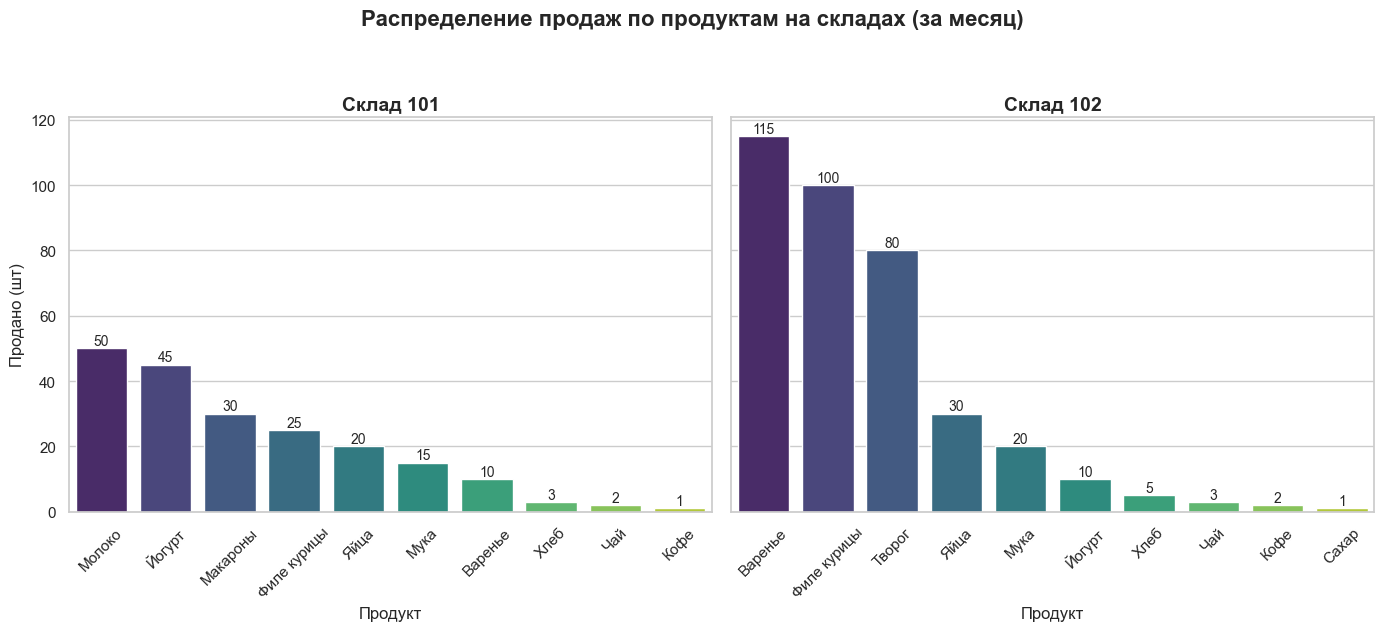

In [13]:
query = """
SELECT 
    o.warehouse_id,
    p.product_name,
    SUM(ol.quantity) as total_sold
FROM orders o
JOIN order_lines ol ON o.order_id = ol.order_id
JOIN products p ON p.product_id = ol.product_id
WHERE o.created_at >= datetime('now', '-1 month')
GROUP BY o.warehouse_id, p.product_name
ORDER BY o.warehouse_id, total_sold DESC;
"""

df = pd.read_sql_query(query, conn)

warehouses = df['warehouse_id'].unique()
n_warehouses = len(warehouses)

fig, axes = plt.subplots(1, n_warehouses, figsize=(7 * n_warehouses, 6), sharey=True)

if n_warehouses == 1:
    axes = [axes]

for i, warehouse in enumerate(warehouses):
    ax = axes[i]
    subset = df[df['warehouse_id'] == warehouse].sort_values('total_sold', ascending=False)
    
    sns.barplot(data=subset, x='product_name', y='total_sold', ax=ax, palette='viridis', hue='product_name', legend=False)
    
    ax.set_title(f'Склад {warehouse}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Продукт', fontsize=12)
    ax.set_ylabel('Продано (шт)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    for j, (_, row) in enumerate(subset.iterrows()):
        ax.text(j, row['total_sold'] + 0.1, str(int(row['total_sold'])), 
                ha='center', va='bottom', fontsize=10)

plt.suptitle('Распределение продаж по продуктам на складах (за месяц)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


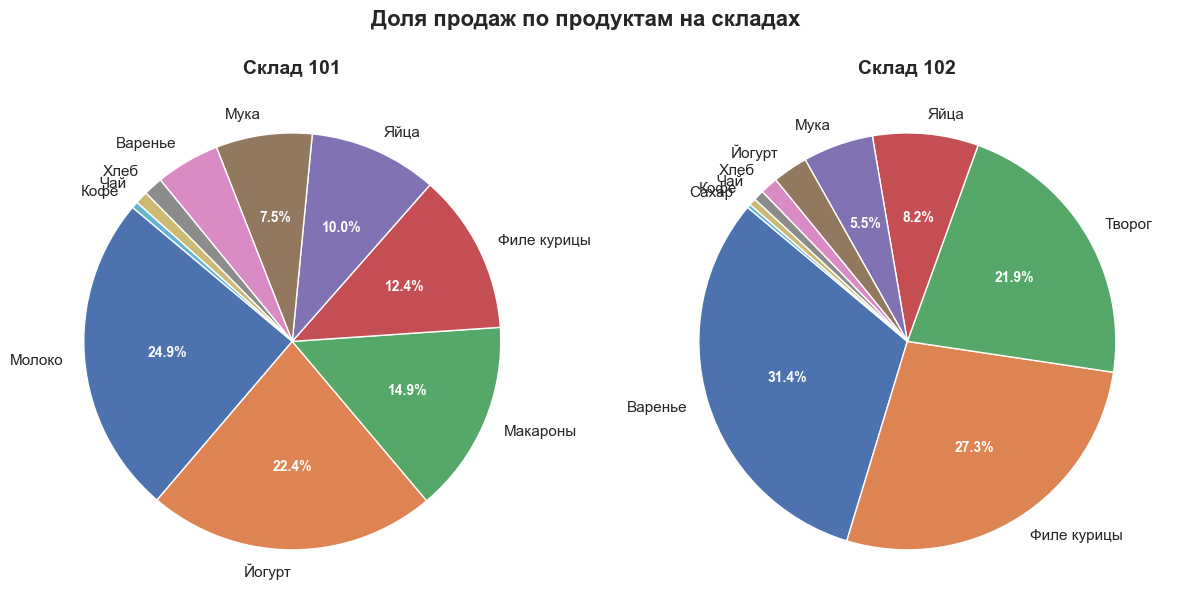

In [22]:
fig, axes = plt.subplots(1, n_warehouses, figsize=(6 * n_warehouses, 6))

if n_warehouses == 1:
    axes = [axes]

def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

for i, warehouse in enumerate(warehouses):
    ax = axes[i]
    subset = df[df['warehouse_id'] == warehouse]
    
    patches, texts, autotexts = ax.pie(
        subset['total_sold'], 
        labels=subset['product_name'], 
        autopct=my_autopct,
        startangle=140,
        wedgeprops={'edgecolor': 'white'}
    )

    plt.setp(autotexts, size=10, weight="bold", color="white")
    
    ax.set_title(f'Склад {warehouse}', fontsize=14, fontweight='bold')

plt.suptitle('Доля продаж по продуктам на складах', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Следующее задание заключается в нахождении доли доставок дольше 15-ти минут в разбивке дням. Для этого мы подсчитываем общее число заказов за день (атрибут *total_orders*) и с помощью оператора условной логики *CASE* находим количество "запоздалых" доставок *late_orders* и их долю, производим агрегацию по дням. Ниже визуализация.

In [8]:
query = '''
SELECT 
    DATE(created_at) AS order_date,
    COUNT(*) AS total_orders,
    SUM(CASE WHEN (julianday(delivered_at) - julianday(created_at)) * 24 * 60 > 15 THEN 1 ELSE 0 END) AS late_orders,
    ROUND(
        100.0 * SUM(CASE WHEN (julianday(delivered_at) - julianday(created_at)) * 24 * 60 > 15 THEN 1 ELSE 0 END) 
        / COUNT(*), 
        2
    ) AS late_percentage
FROM orders
WHERE delivered_at IS NOT NULL AND created_at IS NOT NULL
GROUP BY DATE(created_at)
ORDER BY order_date
''' 

df = pd.read_sql_query(query, conn)

C:\Users\Ruslan Khalikov\AppData\Local\Temp\ipykernel_2284\2888128850.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='order_date', y='late_percentage', data=df, palette='viridis')


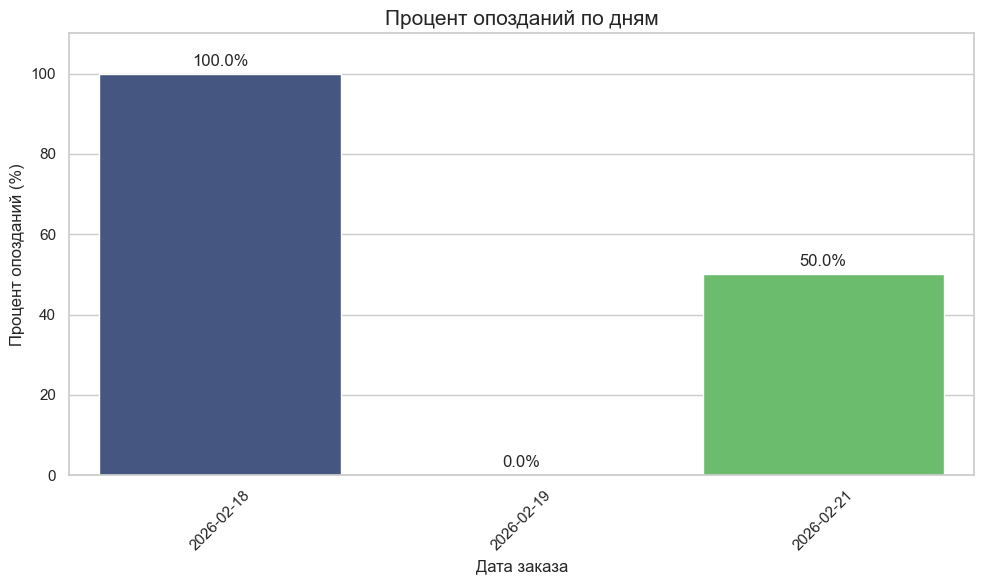

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
plt.figure(figsize=(10, 6))

# Создание графика
ax = sns.barplot(x='order_date', y='late_percentage', data=df, palette='viridis')

# Добавляем подписи значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Процент опозданий по дням', fontsize=15)
plt.xlabel('Дата заказа', fontsize=12)
plt.ylabel('Процент опозданий (%)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 110) # Чтобы текст сверху не обрезался

plt.tight_layout()
plt.show()


Далее, была рассмотрена следующая ситуация. В "Самокате" решили ввести ограничение на количество SKU (Stock Keeping Unit) бутылок воды в одном заказе (не более одной SKU из определенного списка) с целью уменьшить вес заказа. Следует ответить на вопросы:
1. На какие метрики следует смотреть, чтобы оценить эффективность нововведения?
2. Как пользователь может обойти ограничение?
3. Как это проверить с помощью трех таблиц выше? 

1. Так как задача состояла в облегчении заказа, ключевая метрика, на которую необходимо посмотреть, это средний вес заказа. Данная метрика должна была уменьшиться. 
Стоит также посмотреть на количество заказов воды (доля заказов с водой), AOV (Average Order Value, средний чек), Retention Rate (удержание), среднее количество разных SKU воды в заказе.

2. Пользователь может заказывать разные бутылки по одной штуке, или делать последовательно много заказов, или набирая много воды меньшего объема. 

3. Средний вес заказа можно найти просуммировав веса продуктов в составе заказа и усреднив суммарный вес по заказам за период до введения ограничения и после. Долю количества заказов с водой можно найти отфильтровав по наличию в составе заказа SKU из списка, одновременно с тем можно найти и среднее количество разных SKU. AOV можно найти аналогично весу.